In [32]:
import os

working_directory = '/home/jacky_macpro/workspaces/project_2/'
data_directory = os.path.join(working_directory, 'data/')

In [33]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [34]:
topics = pd.read_csv(data_directory + 'topics.csv')
correlations = pd.read_csv(data_directory + 'correlations.csv')
content = pd.read_csv(data_directory + 'content.csv')

In [35]:
def explore_curriculum_data(topics_df, content):
    """
    Perform exploratory data analysis on curriculum recommendation datasets

    Parameters:
    topics_df (pd.DataFrame): Topics dataset
    content (pd.DataFrame): Content dataset

    Returns:
    dict: Dictionary containing analysis results
    """
    analysis = {}

    # Basic dataset info
    analysis['topics_shape'] = topics_df.shape
    analysis['content_shape'] = content.shape

    # Check missing values
    analysis['topics_missing'] = topics_df.isnull().sum()
    analysis['content_missing'] = content.isnull().sum()

    # Analyze topics dataset
    analysis['topic_level_counts'] = topics_df['level'].value_counts()
    analysis['topic_language_counts'] = topics_df['language'].value_counts()

    # Analyze content dataset
    analysis['content_language_counts'] = content['language'].value_counts()
    analysis['content_kind_counts'] = content['kind'].value_counts()

    # Calculate text length statistics
    content['title_length'] = content['title'].str.len()
    content['description_length'] = content['description'].fillna('').str.len()

    analysis['content_title_stats'] = content['title_length'].describe()
    analysis['content_desc_stats'] = content['description_length'].describe()

    # Check relationships
    topics_per_language = topics_df.groupby('language').size()
    content_per_language = content.groupby('language').size()
    analysis['topics_to_content_ratio'] = (topics_per_language / content_per_language).fillna(0)

    return analysis

# Run the analysis
results = explore_curriculum_data(topics, content)

# Print key findings
print("Dataset Dimensions:")
print(f"Topics dataset: {results['topics_shape'][0]:,} rows × {results['topics_shape'][1]} columns")
print(f"Content dataset: {results['content_shape'][0]:,} rows × {results['content_shape'][1]} columns\n")

print("Topic Levels Distribution:")
print(results['topic_level_counts'])
print("\nTop 5 Languages by Topic Count:")
print(results['topic_language_counts'].head())
print("\nTop 5 Content Types:")
print(results['content_kind_counts'].head())
print("\nContent Title Length Statistics:")
print(results['content_title_stats'].round(2))

Dataset Dimensions:
Topics dataset: 76,972 rows × 9 columns
Content dataset: 154,047 rows × 8 columns

Topic Levels Distribution:
level
4     38810
3     14898
5      9744
6      6210
2      4874
1      1104
7      1028
0       171
8       119
9        12
10        2
Name: count, dtype: int64

Top 5 Languages by Topic Count:
language
en    36161
es    13910
pt     4177
ar     3701
fr     3701
Name: count, dtype: int64

Top 5 Content Types:
kind
video       61487
document    33873
html5       32563
exercise    25925
audio         199
Name: count, dtype: int64

Content Title Length Statistics:
count    154038.00
mean         33.83
std          18.11
min           1.00
25%          21.00
50%          31.00
75%          44.00
max         177.00
Name: title_length, dtype: float64


In [36]:
print(topics.shape)
topics.head(10)

(76972, 9)


,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True
5,t_0008768bdee6,100 સુધીનો સરવાળો,37 અને 49 જેવી બે-અંકની સંખ્યાઓ ઉમેરતા શીખો.,5223e0,supplemental,4,gu,t_0da7a331d666,True
6,t_0008a1bd84ba,12. 20: Bird Reproduction,NaN,ebc86c,supplemental,5,en,t_c44ac9711007,True
7,t_000c0c854f0b,Nepal,NaN,f2e966,source,1,en,t_f9c4ef0d6290,False
8,t_000d1fb3f2f5,2.1.2 - Logarithms,NaN,e77b55,aligned,5,en,t_b897d168db90,True
9,t_000feba42136,As vacinas,NaN,8e286a,source,4,pt,t_dfc8ec591573,True


In [37]:
print(content.shape)
content.head(10)

(154047, 10)


,id,title,description,kind,text,language,copyright_holder,license,title_length,description_length
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN,48.0,53
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN,30.0,29
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN,23.0,31
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND,19.0,118
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA,32.0,32
5,c_00019840d110,5.12E: Regulation of the Calvin Cycle,NaN,html5,LEARNING OBJECTIVES\n\nOutline the three major...,en,CSU and Merlot,CC BY-NC-SA,37.0,0
6,c_0001ec56e20f,Reflexionemos sobre lo que vemos y escuchamos,NaN,document,Lección\n\n7\n\nReflexionemos sobre lo que\nve...,es,Publicado por el Lic. Edelberto Andino(edelber...,CC BY-NC-SA,45.0,0
7,c_00025aaa1533,अंग्रेजी ओके प्लीज 1.2,source_url=http://www.prathamopenschool.org/Co...,video,NaN,mr,NaN,NaN,22.0,76
8,c_00027d03ca7d,4.E: Genomes and Chromosomes (Exercises),NaN,html5,4.3\n\n(BPA) Answer the following questions wi...,en,CSU and Merlot,CC BY-NC-SA,40.0,0
9,c_000314eb850f,La banca 12: los bonos del tesoro (deuda pública),Introducción a la deuda y los fondos públicos....,video,NaN,es,NaN,NaN,49.0,194


In [38]:
print(correlations.shape)
correlations.head()

(61517, 2)


,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4


In [39]:
#creating mapping dictionaries for parent and title
title_map = topics.set_index("id")["title"].to_dict()
parent_map = topics.set_index("id")["parent"].to_dict()

#addign parent title columns
topics["parent_title"] = topics["parent"].apply(lambda x: title_map.get(x, ""))
print(topics.shape)

#addding grandpa title
topics["grandpa"] = topics["parent"].apply(lambda x: parent_map.get(x))
topics["grandpa_title"] = topics["grandpa"].apply(lambda x: title_map.get(x, ""))
print(topics.shape)

#adding great grandpa title
topics["ggrandpa"] = topics["grandpa"].apply(lambda x: parent_map.get(x))
topics["ggrandpa_title"] = topics["ggrandpa"].apply(lambda x: title_map.get(x, ""))
print(topics.shape)

#fill in missing parent values
topics["parent"] = topics["parent"].fillna(topics["id"])


(76972, 10)
(76972, 12)
(76972, 14)


In [40]:
def extract_number(x, is_subtopic=False):
    chapter, rest = x.split(":", 1)

    if is_subtopic:
        chapter = chapter.split(".", 1)[0]
        x = f"{chapter}:{rest}"
    chapter = int(chapter)

    return chapter, x

def extract_chapters(df, is_subtopic):
    titles = df["title"].fillna("").values

    chapters = np.zeros(len(titles))
    new_titles = np.array(titles)

    for i, title in enumerate(titles):
        try:
            chapters[i], new_titles[i] = extract_number(title, is_subtopic)
        except:
            pass

    df["chapter"], df["title"] = chapters, new_titles
    df["chapter"] = df["chapter"].astype(int)

    df.loc[df["chapter"] == 0, "chapter"] = None
    return df



In [41]:

content["t"] = content["title"].fillna("") + " | " + content["kind"].fillna("") + " | " + content["description"].fillna("")

topics = extract_chapters(topics, False)
content = extract_chapters(content, True)

topics["t"] = topics["title"] + " @ " + topics["parent_title"] + " @ " + topics["grandpa_title"] + " @ " + topics["ggrandpa_title"] + " | " + topics["description"].fillna("")


In [42]:
topics[topics['language'] == 'en'].head()

,id,title,description,channel,category,level,language,parent,has_content,parent_title,grandpa,grandpa_title,ggrandpa,ggrandpa_title,chapter,t
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False,Junior High Level 3,t_a7bda143557e,Ghana JHS Curriculum (in progress),NaN,,NaN,Unit 3.3 Enlargements and Similarities @ Junio...
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True,Flow Charts: Logical Thinking?,t_acbbd893e6af,Engineering,t_9c5f09334d83,MIT Blossoms,NaN,Transcripts @ Flow Charts: Logical Thinking? @...
6,t_0008a1bd84ba,12. 20: Bird Reproduction,NaN,ebc86c,supplemental,5,en,t_c44ac9711007,True,12: Vertebrates,t_9be861f67172,Book: Introductory Biology,t_ee558ee40155,Introductory and General Biology,NaN,12. 20: Bird Reproduction @ 12: Vertebrates @ ...
7,t_000c0c854f0b,Nepal,NaN,f2e966,source,1,en,t_f9c4ef0d6290,False,Touchable Earth (en),NaN,,None,,NaN,Nepal @ Touchable Earth (en) @ @ |
8,t_000d1fb3f2f5,2.1.2 - Logarithms,NaN,e77b55,aligned,5,en,t_b897d168db90,True,2.1 - Exponents and Logarithms,t_fa5b4d3f322b,Unit 2 - Exponential and Logarithmic Functions,t_b1104358008a,Mathematics,NaN,2.1.2 - Logarithms @ 2.1 - Exponents and Logar...


In [46]:
topics_title = pd.DataFrame(topics['title'].value_counts())
topics_title['title'] = topics_title.index
print(topics_title.head(n = 20))

              count         title
title                            
Assessments     558   Assessments
Videos          341        Videos
Explore         322       Explore
Lección 1       306     Lección 1
Lección 2       280     Lección 2
Lección 3       238     Lección 3
Lección 4       197     Lección 4
Lección 5       183     Lección 5
Lección 7       179     Lección 7
Lección 6       179     Lección 6
Lección 8       171     Lección 8
For Teachers    163  For Teachers
Transcripts     152   Transcripts
Lección 10      104    Lección 10
Lección 11      103    Lección 11
Lección 12      102    Lección 12
Lección 13      102    Lección 13
Lección 14      100    Lección 14
Lección 15       97    Lección 15
Lección 16       96    Lección 16


In [51]:
fig, ax = plt.subplots()

ax.barh(width=topics_title['count'], y=topics_title['title'], height=1)

plt.show()


/home/jacky_macpro/workspaces/project_2/.learning_equality/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2472 (\N{BENGALI LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jacky_macpro/workspaces/project_2/.learning_equality/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jacky_macpro/workspaces/project_2/.learning_equality/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jacky_macpro/workspaces/project_2/.learning_equality/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2460 (\N{BENGALI LETTER JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jacky_macpro/workspaces/proj

ValueError: 
\blue{ 3}
^
ParseFatalException: Unknown symbol: \blue, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 1 Axes>

In [ ]:
plot_histogram(topics, 'title')

/home/jacky_macpro/workspaces/project_2/.learning_equality/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2744 (\N{GUJARATI LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jacky_macpro/workspaces/project_2/.learning_equality/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Gujarati natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jacky_macpro/workspaces/project_2/.learning_equality/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2753 (\N{GUJARATI VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jacky_macpro/workspaces/project_2/.learning_equality/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2727 (\N{GUJARATI LETTER DHA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jacky_macpro/workspaces

ValueError: 
\blue{ 3}
^
ParseFatalException: Unknown symbol: \blue, found '\'  (at char 0), (line:1, col:1)

<Figure size 800x600 with 1 Axes>

TypeError: 'value' must be an instance of str or bytes, not a float

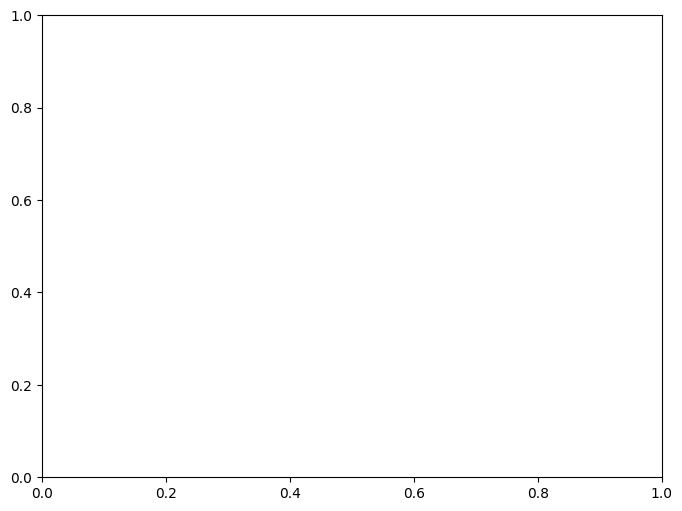

In [ ]:
plot_histogram(topics, 'parent_title')

In [ ]:
plot_histogram(topics, 'grandpa_title')

In [ ]:
plot_histogram(topics, 'ggrandpa_title')